# Enzyme binding-site mapping + clustering (Biotite + AtomWorks)

In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd

import biotite.structure as struc
from atomworks.io import parse

from scipy.spatial import cKDTree
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt


Environment variable CCD_MIRROR_PATH not set. Will not be able to use function requiring this variable. To set it you may:
  (1) add the line 'export VAR_NAME=path/to/variable' to your .bashrc or .zshrc file
  (2) set it in your current shell with 'export VAR_NAME=path/to/variable'
  (3) write it to a .env file in the root of the atomworks.io repository
Environment variable PDB_MIRROR_PATH not set. Will not be able to use function requiring this variable. To set it you may:
  (1) add the line 'export VAR_NAME=path/to/variable' to your .bashrc or .zshrc file
  (2) set it in your current shell with 'export VAR_NAME=path/to/variable'
  (3) write it to a .env file in the root of the atomworks.io repository


Imports OK


## Download 10 trypsin–inhibitor mmCIF files

RCSB download pattern:
`https://files.rcsb.org/download/<PDBID>.cif`


In [2]:
import urllib.request

PDB_IDS = [
    '1BTY', '5MNG', '2AYW', '1G36', '1K1J',
    '3OTJ', '2FTL', '3FP6', '4Y0Y', '6YIV',
]

OUT_DIR = Path('./cifs_trypsin')
OUT_DIR.mkdir(parents=True, exist_ok=True)

def download_cif(pdb_id: str, out_dir: Path) -> Path:
    pdb_id = pdb_id.lower()
    url = f'https://files.rcsb.org/download/{pdb_id}.cif'
    out_path = out_dir / f'{pdb_id}.cif'
    if out_path.exists() and out_path.stat().st_size > 0:
        return out_path
    urllib.request.urlretrieve(url, out_path)
    return out_path

cif_paths = []
for pid in PDB_IDS:
    p = download_cif(pid, OUT_DIR)
    cif_paths.append(p)

print('Downloaded:', len(cif_paths))
cif_paths[:3]

Downloaded: 10


[PosixPath('cifs_trypsin/1bty.cif'),
 PosixPath('cifs_trypsin/5mng.cif'),
 PosixPath('cifs_trypsin/2ayw.cif')]

## Parse CIF → AtomArray (AtomWorks)

We parse assembly 1 by default. 


In [3]:
ASSEMBLY_ID = '1'

def safe_parse_cif(path: Path, assembly_id: str = '1'):
    try:
        out = parse(
            filename=str(path),
            build_assembly=(assembly_id,),
            add_missing_atoms=False,
            fix_formal_charges=False,
            add_id_and_entity_annotations=True,
        )
        return out['assemblies'][assembly_id][0]
    except Exception as e:
        print('parse failed:', path.name, repr(e))
        return None

aa0 = safe_parse_cif(cif_paths[0], ASSEMBLY_ID)
print('Atoms:', None if aa0 is None else len(aa0))
print('Chain IDs (unique):', None if aa0 is None else sorted(set(map(str, np.unique(aa0.chain_id)))))

Atoms: 3234
Chain IDs (unique): ['A', 'B', 'C']


## Define receptor vs partner

For trypsin–BPTI complexes, a common mapping is:
- receptor (enzyme) chain: `A`
- partner (inhibitor) chain: `B`

But chain IDs can differ across entries, so we will print chain IDs per structure and you can adjust.


In [17]:
RECEPTOR_CHAIN = 'A'
PARTNER_CHAIN = 'B'


for p in cif_paths:
    aa = safe_parse_cif(p, ASSEMBLY_ID)
    if aa is None:
        continue
    ch = sorted(set(map(str, np.unique(aa.chain_id))))

    # print(aa.get_annotation_categories())
    
    # print the row that res_name is not water and is_polymer is False
    non_poly_het = aa[(~aa.is_polymer) & (aa.res_name != 'HOH')]
    print('Unique residue names:', np.unique(non_poly_het.res_name))
    
    BEN = non_poly_het[non_poly_het.res_name == 'BEN']
    print('BEN atoms:', len(BEN))
    
    print(BEN.chain_iid)

# in the end we only look into the cif files that contain BEN
cif_paths_with_ben = []
for p in cif_paths:
    aa = safe_parse_cif(p, ASSEMBLY_ID)
    if aa is None:
        continue
    non_poly_het = aa[(~aa.is_polymer) & (aa.res_name != 'HOH')]
    BEN = non_poly_het[non_poly_het.res_name == 'BEN']
    if len(BEN) > 0:
        cif_paths_with_ben.append(p)
        
print('CIFs with BEN:', len(cif_paths_with_ben))
cif_paths_with_ben[:3]


Unique residue names: ['BEN' 'CA']
BEN atoms: 16
['C_1' 'C_1' 'C_1' 'C_1' 'C_1' 'C_1' 'C_1' 'C_1' 'C_1' 'C_1' 'C_1' 'C_1'
 'C_1' 'C_1' 'C_1' 'C_1']
Unique residue names: ['BEN' 'CA']
BEN atoms: 14
['G_1' 'G_1' 'G_1' 'G_1' 'G_1' 'G_1' 'G_1' 'G_1' 'G_1' 'G_1' 'G_1' 'G_1'
 'G_1' 'G_1']
Unique residue names: ['1NJ' 'BEN' 'CA']
BEN atoms: 9
['E_1' 'E_1' 'E_1' 'E_1' 'E_1' 'E_1' 'E_1' 'E_1' 'E_1']
Unique residue names: ['CA' 'R11']
BEN atoms: 0
[]
Unique residue names: ['CA' 'FD2']
BEN atoms: 0
[]
parse failed: 3otj.cif TypeError("int() argument must be a string, a bytes-like object or a real number, not 'NoneType'")


Error resolving arginine naming ambiguity: operands could not be broadcast together with shapes (10,3) (9,3) . Returning original atom array.


Unique residue names: ['CA' 'NA']
BEN atoms: 0
[]
Unique residue names: ['CA']
BEN atoms: 0
[]
Unique residue names: ['CA']
BEN atoms: 0
[]
Unique residue names: ['D86']
BEN atoms: 0
[]
parse failed: 3otj.cif TypeError("int() argument must be a string, a bytes-like object or a real number, not 'NoneType'")


Error resolving arginine naming ambiguity: operands could not be broadcast together with shapes (10,3) (9,3) . Returning original atom array.


CIFs with BEN: 3


[PosixPath('cifs_trypsin/1bty.cif'),
 PosixPath('cifs_trypsin/5mng.cif'),
 PosixPath('cifs_trypsin/2ayw.cif')]

## Geometry: contact masks using Biotite CellList

We compute atom-level contact masks, then lift them to residue-level binding-site definitions.


In [49]:
CONTACT_CUTOFF_A = 5.0
CLASH_CUTOFF_A = 1.0

def contact_stats_between_atom_sets(coord1, coord2,contact_cutoff= 5.0,clash_cutoff = 1.0,cell_size= 6.0):
    v1 = ~np.isnan(coord1).any(axis=1)
    v2 = ~np.isnan(coord2).any(axis=1)
    coord1_f = coord1[v1]
    coord2_f = coord2[v2]

    cl = struc.CellList(coord2_f, cell_size=cell_size)
    near_c = cl.get_atoms(coord1_f, contact_cutoff, as_mask=True)  # (n1_f, n2_f)
    # how many cor1 has neighbor
    has_c_f = np.any(near_c, axis=1)
    n_contacts = int(has_c_f.sum())

    min_dist = float('inf')
    if n_contacts > 0:
        for i_f, rowmask in enumerate(near_c):
            # if find the row that dont have any neighbor
            if not np.any(rowmask):
                continue
            d = np.linalg.norm(coord2_f[rowmask] - coord1_f[i_f], axis=1)
            md = float(d.min())
            if md < min_dist:
                min_dist = md

    # how many cor1 has neighbor in clash_cutoff
    near_2 = cl.get_atoms(coord1_f, clash_cutoff, as_mask=True)
    clash_count = int(np.any(near_2, axis=1).sum())

    n1_full = len(v1)
    has_c = np.zeros((n1_full,), dtype=bool)
    has_c[v1] = has_c_f
    return n_contacts, min_dist, clash_count, has_c

def interface_masks(receptor_atoms, partner_atoms):
    n_contacts, min_dist, clash_count, rec_mask = contact_stats_between_atom_sets(
        receptor_atoms.coord, partner_atoms.coord,
        contact_cutoff=CONTACT_CUTOFF_A,
        clash_cutoff=CLASH_CUTOFF_A,
        cell_size=max(6.0, CONTACT_CUTOFF_A + 1.0),
    )
    _, _, _, par_mask = contact_stats_between_atom_sets(
        partner_atoms.coord, receptor_atoms.coord,
        contact_cutoff=CONTACT_CUTOFF_A,
        clash_cutoff=CLASH_CUTOFF_A,
        cell_size=max(6.0, CONTACT_CUTOFF_A + 1.0),
    )
    return n_contacts, min_dist, clash_count, rec_mask, par_mask

aa = safe_parse_cif(cif_paths_with_ben[0], ASSEMBLY_ID)

rec = aa[aa.chain_id == 'A']
 
# this should be ligand BEN
par = aa[aa.res_name == 'BEN']

nC, dmin, nclash, rec_mask, par_mask = interface_masks(rec, par)
print('n_contacts:', nC, 'min_dist:', dmin, 'clashes:', nclash)
print('receptor atoms in contact:', int(rec_mask.sum()), '/', len(rec))

print(rec_mask)
rec_idx = np.where(rec_mask == True)[0]
par_idx = np.where(par_mask == True)[0]

print(rec_idx)
print(par_idx)

rec[rec_idx] # or in fact rec[rec_mask]


n_contacts: 118 min_dist: 1.9067354202270508 clashes: 0
receptor atoms in contact: 118 / 3217
[False False False ... False False False]
[ 553  560 2462 2463 2465 2466 2467 2468 2470 2471 2472 2473 2474 2475
 2476 2477 2478 2479 2481 2482 2483 2484 2485 2486 2487 2490 2491 2494
 2495 2499 2500 2501 2502 2503 2504 2508 2509 2510 2515 2520 2522 2526
 2528 2530 2531 2534 2535 2536 2537 2538 2539 2540 2714 2715 2716 2717
 2718 2721 2722 2723 2724 2725 2729 2730 2731 2732 2735 2736 2740 2741
 2742 2743 2754 2755 2756 2764 2765 2766 2767 2768 2769 2770 2771 2773
 2777 2782 2783 2784 2785 2786 2787 2789 2790 2791 2793 2794 2796 2798
 2799 2804 2886 2887 2898 2899 2900 2902 2903 2904 2905 2908 2912 2929
 2930 2931 2932 2939 2940 2941]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


AtomArray([
	Atom(np.array([24.823, 12.937, 22.885], dtype=float32), chain_id="A", res_id=46, ins_code="", res_name="HIS", hetero=False, atom_name="NE2", element="N", atom_id=565, b_factor=15.36, occupancy=1.0, charge=0, label_entity_id="1", auth_seq_id="57", is_polymer=True, chain_type=6, pn_unit_id="A", molecule_id=0, chain_entity=0, pn_unit_entity=0, molecule_entity=0, atomic_number=7, transformation_id="1", chain_iid="A_1", pn_unit_iid="A_1", molecule_iid=0),
	Atom(np.array([23.974, 14.469, 21.703], dtype=float32), chain_id="A", res_id=46, ins_code="", res_name="HIS", hetero=False, atom_name="HE1", element="H", atom_id=572, b_factor=14.49, occupancy=1.0, charge=0, label_entity_id="1", auth_seq_id="57", is_polymer=True, chain_type=6, pn_unit_id="A", molecule_id=0, chain_entity=0, pn_unit_entity=0, molecule_entity=0, atomic_number=1, transformation_id="1", chain_iid="A_1", pn_unit_iid="A_1", molecule_iid=0),
	Atom(np.array([33.06 , 20.197, 13.754], dtype=float32), chain_id="A", res_i

## Binding-site representation: residue set + representative points

We represent a binding site on the receptor by:
- `site_set`: frozenset of (chain, res_id, ins, res_name)
- `site_points`: CA coords per binding-site residue (or residue centroid)

These are the objects we cluster.


In [ ]:
def _norm_ins(x):
    return '' if (x is None or str(x).strip() == '') else str(x)

def residue_keys(atom_array):
    ins = [_norm_ins(x) for x in atom_array.ins_code]
    return list(zip(map(str, atom_array.chain_id), map(int, atom_array.res_id), ins))

def binding_site_repr(receptor, receptor_contact_mask):
    keys = residue_keys(receptor)  # list[tuple]
    hit = {keys[i] for i in np.where(receptor_contact_mask)[0]}

    if not hit:
        return {
            'site_set': frozenset(),
            'site_points': np.zeros((0, 3), dtype=float),
            'site_resi_resn': '',
            'site_centroid_x': np.nan,
            'site_centroid_y': np.nan,
            'site_centroid_z': np.nan,
            'site_rg': np.nan,
        }

    ins_arr = np.array([_norm_ins(x) for x in receptor.ins_code], dtype=object)

    def key_sort(k):
        ch, rid, ins = k
        return (str(ch), int(rid), str(ins))

    site_set = []
    items = []
    points = []

    for ch, rid, ins in sorted(hit, key=key_sort):
        ins_s = _norm_ins(ins)
        m = (receptor.chain_id == ch) & (receptor.res_id == rid)
        m = m & (ins_arr == ins_s)
        if not np.any(m):
            continue

        resn = str(receptor.res_name[m][0])
        resi_str = f"{ch}:{int(rid)}{ins_s}"

        m_ca = m & (receptor.atom_name == 'CA')
        if np.any(m_ca):
            p = receptor.coord[m_ca][0]
        else:
            p = np.nanmean(receptor.coord[m], axis=0)
        if np.isnan(p).any():
            continue

        site_set.append((str(ch), int(rid), ins_s, resn))
        items.append(f"{resi_str}:{resn}")
        points.append(p)

    if len(points) == 0:
        P = np.zeros((0, 3), dtype=float)
        cx = cy = cz = np.nan
        rg = np.nan
    else:
        P = np.vstack(points).astype(float)
        C = P.mean(axis=0)
        cx, cy, cz = map(float, C.tolist())
        rg = float(np.sqrt(np.mean(np.sum((P - C) ** 2, axis=1))))

    return {
        'site_set': frozenset(site_set),
        'site_points': P,
        'site_resi_resn': ';'.join(items),
        'site_centroid_x': cx,
        'site_centroid_y': cy,
        'site_centroid_z': cz,
        'site_rg': rg,
    }

site0 = binding_site_repr(rec, rec_mask)
print('binding-site residues:', len(site0['site_set']))
print('point cloud shape:', site0['site_points'].shape)
print('rg:', site0['site_rg'])
print('example residues:', site0['site_resi_resn'][:200], '...')

binding-site residues: 20
point cloud shape: (20, 3)
rg: 6.975156616286565
example residues: A:46:HIS;A:177:ASP;A:178:SER;A:179:CYS;A:180:GLN;A:181:GLY;A:182:ASP;A:183:SER;A:197:VAL;A:198:SER;A:199:TRP;A:200:GLY;A:201:SER;A:202:GLY;A:203:CYS;A:204:ALA;A:209:PRO;A:210:GLY;A:211:VAL;A:212:TYR ...


## Build binding-site dataset across structures

We compute the receptor binding site relative to the partner chain for each CIF.
If a structure lacks the needed chains, we skip it.


In [51]:
MIN_CONTACTS_KEEP = 1

rows = []
skipped = []
for p in cif_paths_with_ben:
    aa = safe_parse_cif(p, ASSEMBLY_ID)
    rec = aa[aa.chain_id == 'A']
    par = aa[aa.res_name == 'BEN']

    nC, dmin, nclash, rec_mask, par_mask = interface_masks(rec, par)
    
    if nC < MIN_CONTACTS_KEEP:
        skipped.append((p.name, 'too_few_contacts'))
        continue

    site = binding_site_repr(rec, rec_mask)
    
    rows.append({
        'path': str(p.resolve()),
        'pdb_id': p.stem.upper(),
        'n_contacts_atoms': int(nC),
        'min_dist_A': float(dmin),
        'clash_count_atoms': int(nclash),
        'site_size_res': int(len(site['site_set'])),
        'site_set': site['site_set'],
        'site_points': site['site_points'],
        'site_rg': site['site_rg'],
        'site_resi_resn': site['site_resi_resn'],
    })

df = pd.DataFrame(rows)
print('Kept:', len(df), 'Skipped:', len(skipped))
df[['pdb_id','n_contacts_atoms','site_size_res','site_rg']].head(10)

Kept: 3 Skipped: 0


,pdb_id,n_contacts_atoms,site_size_res,site_rg
0,1BTY,118,20,6.975157
1,5MNG,105,21,7.272561
2,2AYW,1,1,0.000000


## Distance metrics: Jaccard / Chamfer / Hybrid

Hybrid distance:
d = alpha*(1 - Jaccard) + (1-alpha)*clip(Chamfer/d0, 0, 1)


In [52]:
def jaccard_distance(a: frozenset, b: frozenset) -> float:
    if not a and not b:
        return 0.0
    inter = len(a & b)
    uni = len(a | b)
    return 1.0 - (inter / uni if uni > 0 else 0.0)

def chamfer_distance(P: np.ndarray, Q: np.ndarray) -> float:
    if P.size == 0 and Q.size == 0:
        return 0.0
    if P.size == 0 or Q.size == 0:
        return float('inf')
    tQ = cKDTree(Q)
    dP, _ = tQ.query(P, k=1)
    tP = cKDTree(P)
    dQ, _ = tP.query(Q, k=1)
    return float(dP.mean() + dQ.mean())

def pairwise_distance_matrix(site_sets, site_points, metric='hybrid', alpha=0.8, d0=10.0, chamfer_inf_cap=1e6):
    n = len(site_sets)
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i + 1, n):
            dj = jaccard_distance(site_sets[i], site_sets[j])
            if metric == 'jaccard':
                d = dj
            else:
                dc = chamfer_distance(site_points[i], site_points[j])
                if metric == 'chamfer':
                    d = float(dc if np.isfinite(dc) else chamfer_inf_cap)
                elif metric == 'hybrid':
                    dc_norm = 1.0 if not np.isfinite(dc) else float(np.clip(dc / d0, 0.0, 1.0))
                    d = float(alpha * dj + (1.0 - alpha) * dc_norm)
                else:
                    raise ValueError(f'Unknown metric: {metric}')
            D[i, j] = D[j, i] = d
    return D

print('OK')

OK


## Cluster binding sites

We use average-linkage hierarchical clustering on the distance matrix.


In [53]:
CLUSTER_METRIC = 'hybrid'   # jaccard | chamfer | hybrid
ALPHA = 0.8
D0 = 10.0
K = 5  # you can change; use <= len(df)

if len(df) < 2:
    print('Need at least 2 structures to cluster.')
else:
    site_sets = df['site_set'].tolist()
    site_points = df['site_points'].tolist()
    D = pairwise_distance_matrix(site_sets, site_points, metric=CLUSTER_METRIC, alpha=ALPHA, d0=D0)
    Z = linkage(squareform(D, checks=False), method='average')
    k_used = min(K, len(df))
    labels = fcluster(Z, t=k_used, criterion='maxclust').astype(int)
    df = df.copy()
    df['cluster'] = labels
    print('k_used:', k_used)
    display(df[['pdb_id','n_contacts_atoms','site_size_res','site_rg','cluster']].sort_values(['cluster','pdb_id']))
    print(df['cluster'].value_counts().sort_index())

k_used: 3


,pdb_id,n_contacts_atoms,site_size_res,site_rg,cluster
0,1BTY,118,20,6.975157,1
1,5MNG,105,21,7.272561,2
2,2AYW,1,1,0.000000,3


cluster
1    1
2    1
3    1
Name: count, dtype: int64


## Heatmap (small N)
Useful to eyeball whether clusters make sense.


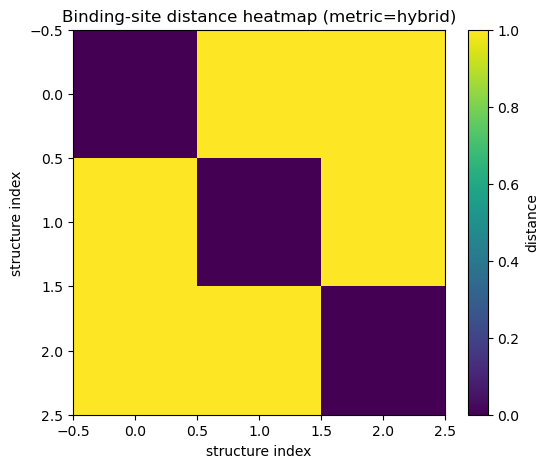

In [54]:
if len(df) >= 2:
    site_sets = df['site_set'].tolist()
    site_points = df['site_points'].tolist()
    D = pairwise_distance_matrix(site_sets, site_points, metric=CLUSTER_METRIC, alpha=ALPHA, d0=D0)
    plt.figure(figsize=(6,5))
    plt.imshow(D, aspect='auto')
    plt.colorbar(label='distance')
    plt.title(f'Binding-site distance heatmap (metric={CLUSTER_METRIC})')
    plt.xlabel('structure index')
    plt.ylabel('structure index')
    plt.show()

## Inspect clusters: what residues define them?

We print a few representatives and the first site's residue string.


In [55]:
if 'cluster' in df.columns:
    for cid, sub in df.groupby('cluster'):
        print('\n=== Cluster', cid, 'n=', len(sub), '===')
        display(sub[['pdb_id','site_size_res','site_rg','n_contacts_atoms','min_dist_A']].head(5))
        print('Example binding-site residues:')
        print(sub['site_resi_resn'].iloc[0][:400], '...')


=== Cluster 1 n= 1 ===


,pdb_id,site_size_res,site_rg,n_contacts_atoms,min_dist_A
0,1BTY,20,6.975157,118,1.906735


Example binding-site residues:
A:46:HIS;A:177:ASP;A:178:SER;A:179:CYS;A:180:GLN;A:181:GLY;A:182:ASP;A:183:SER;A:197:VAL;A:198:SER;A:199:TRP;A:200:GLY;A:201:SER;A:202:GLY;A:203:CYS;A:204:ALA;A:209:PRO;A:210:GLY;A:211:VAL;A:212:TYR ...

=== Cluster 2 n= 1 ===


,pdb_id,site_size_res,site_rg,n_contacts_atoms,min_dist_A
1,5MNG,21,7.272561,105,2.033017


Example binding-site residues:
A:40:HIS;A:152:TYR;A:171:ASP;A:172:SER;A:173:CYS;A:174:GLN;A:176:ASP;A:177:SER;A:191:VAL;A:192:SER;A:193:TRP;A:194:GLY;A:195:SER;A:196:GLY;A:197:CYS;A:198:ALA;A:202:LYS;A:203:PRO;A:204:GLY;A:205:VAL;A:206:TYR ...

=== Cluster 3 n= 1 ===


,pdb_id,site_size_res,site_rg,n_contacts_atoms,min_dist_A
2,2AYW,1,0.0,1,4.453904


Example binding-site residues:
A:139:LYS ...
